# Object localization - Bounding Box

---



###Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###Defining path

In [2]:
# PATH = "/content/drive/My Drive/COLAB FILES/capstone project/"

###downloading yolo



In [3]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

# Install dependencies
%pip install -qr requirements.txt  

# change directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12173, done.
remote: Total 12173 (delta 0), reused 0 (delta 0), pack-reused 12173
Receiving objects: 100% (12173/12173), 11.96 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (8428/8428), done.
/content/yolov5
     |████████████████████████████████| 596 kB 32.7 MB/s 
/content
Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


###Necessary/extra dependencies

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import gc
import cv2

from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
from glob import glob
import yaml

###HYPERPARAMETERS

In [5]:
PATH = "/content/drive/My Drive/"
TRAIN_CSV_PATH=PATH+'stage_2_train_labels.csv'
TRAIN_PATH=PATH+"stage_2_train_images"
JPG_TRAIN_PATH=PATH+"JPG_stage_2_train"
IMG_SIZE=1024
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
# # Load image level csv file
# df = pd.read_csv('../input/siimcovid19-detection-training-label/train_image_df.csv')
# # Add absolute path
# df['path'] = df.apply(lambda row: TRAIN_PATH+row.id+'.jpg', axis=1)
# df.head(3)

# SPLITTING DATA TO TRAIN AND VALID

###Creating DIRECTORIES

In [7]:
os.makedirs('pn_data/images/train', exist_ok=True)
os.makedirs('pn_data/images/valid', exist_ok=True)
os.makedirs('pn_data/labels/train', exist_ok=True)
os.makedirs('pn_data/labels/valid', exist_ok=True)

### 1.1Convert Train dcm files to jpg(stage_2_train_images) saved as folder JPG_train



In [8]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 31.8 MB/s 


In [9]:
import pydicom as dicom
import pydicom.uid
import os
import cv2
import PIL # optional

# # make it True if you want in PNG format
# PNG = False
# # Specify the .dcm folder path
# folder_path = PATH+"stage_2_train_images"
# # Specify the output jpg/png folder path
# jpg_folder_path = PATH+"JPG_stage_2_train"
# if not os.path.exists(jpg_folder_path): os.makedirs(jpg_folder_path)
# images_path = os.listdir(folder_path)
# for n, image in enumerate(images_path):
#     ds = dicom.dcmread(os.path.join(folder_path, image),force=True)
#     #ds.file_meta.TransferSyntaxUID = pydicom.uid.SimpleITK  # or whatever is the correct transfer syntax for the file
#     pixel_array_numpy = ds.pixel_array
#     if PNG == False:
#         image = image.replace('.dcm', '.jpg')
#     else:
#         image = image.replace('.dcm', '.png')
#     cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
#     if n % 50 == 0:
#         print('{} image converted'.format(n))


### 1.2 Convert Test dcm files to jpg(stage_2_test_images) saved as JPG_test

In [10]:
# # make it True if you want in PNG format
# PNG = False
# # Specify the .dcm folder path
# folder_path = PATH+"stage_2_test_images"
# # Specify the output jpg/png folder path
# jpg_folder_path = PATH+"JPG_test"
# if not os.path.exists(jpg_folder_path): os.makedirs(jpg_folder_path)
# images_path = os.listdir(folder_path)
# for n, image in enumerate(images_path):
#     ds = dicom.dcmread(os.path.join(folder_path, image))
#     pixel_array_numpy = ds.pixel_array
#     if PNG == False:
#         image = image.replace('.dcm', '.jpg') 
#     else:
#         image = image.replace('.dcm', '.png')
#     cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
#     if n % 50 == 0:
#         print('{} image converted'.format(n))

####Checking for no. of images in the jpg folder

In [11]:
filenames = os.listdir(JPG_TRAIN_PATH)
total_images = len(filenames)
print ("Total images  ", total_images)

Total images   8127


###2.1Defining function for copying files from JPG_TRAIN to train_jpg and valid_jpg

In [12]:
import random
percentage_of_train = 0.8    # 80% = 0.8

def split_dataset_in_train_and_valid( filenames, percentage_of_train):
  
  total_images = len(filenames)
  total_train = int(total_images * percentage_of_train)
  
  set_train = []
  
  while (len(set_train) != total_train):     
    num_image = random.randrange(total_images)
    if num_image not in set_train:
      set_train.append(num_image)

  set_valid = []
  for i in range(total_images):
    if i not in set_train:
      set_valid.append(i)
    
  images_train =[]
  for i in set_train:    
    images_train.append(filenames[i])
   
  images_valid =[]
  for i in set_valid:    
    images_valid.append(filenames[i])
  
  return (images_train, images_valid)

In [13]:
images=split_dataset_in_train_and_valid( filenames, percentage_of_train)

In [14]:
len(images[0])

6501

In [15]:
os.getcwd()

'/content'

In [16]:
!ls

drive  pn_data	sample_data  yolov5


In [17]:
os. getcwd()

'/content'

In [18]:
!ls

drive  pn_data	sample_data  yolov5


###2.2 Copying files from JPG_TRAIN to train_jpg and valid_jpg

In [19]:
## Copy files from sources to train
JPG_TRAIN_PATH = PATH+"JPG_stage_2_train/"
## copy  train set
print ("Copying train")
length = len(images[0])
for i in range(length):
    src =(JPG_TRAIN_PATH+ images[0][i])
    dst =("/content/pn_data/images/train/"+images[0][i])
    copyfile(src, dst)
  

train_images=os.listdir("/content/pn_data/images/train")
print(f"Number of train images : {len(train_images)}")

Copying train
Number of train images : 6501


In [20]:
len (images[1])

1626

In [21]:
## copy Validation set
print ("Copying  validation")
JPG_TRAIN_PATH=PATH+"JPG_stage_2_train/"
length = len (images[1])
for i in range(length):
  src = (JPG_TRAIN_PATH+images[1][i])
  dst = ("/content/pn_data/images/valid/" + images[1][i])
  copyfile(src, dst)
  

valid_images=os.listdir("/content/pn_data/images/valid")
print(f"Number of valid images : {len(valid_images)}")


Copying  validation
Number of valid images : 1626


###Creating YAML file

In [22]:
with open('/content/pn_data/train.txt', 'w') as f:
    for path in glob('//content/pn_data/images/train*'):
        f.write(path+'\n')
            
with open('/content/pn_data/val.txt', 'w') as f:
    for path in glob('/content/pn_data/images/val/*'):
        f.write(path+'\n')

data = dict(
    train = '/content/pn_data/images/train',
    val = '/content/pn_data/images/valid',
    
    nc    = 1, # number of classes
    names =["pneumonia"]# classes
    )

with open('/content/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open('/content/yolov5/data/data.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- pneumonia
nc: 1
train: /content/pn_data/images/train
val: /content/pn_data/images/valid



In [23]:
# # Create .yaml file 
# import yaml

# pneumonia_yaml = dict(
#     train =PATH+'tmp/images/train_jpg',
#     val = PATH+'tmp/images/valid_jpg',
#     nc = 2,
#     names = ['0', '1']
# )

# # Note that I am creating the file in the yolov5/data/ directory.
# with open('tmp/yolov5/data.yaml', 'w') as outfile:
#     yaml.dump(pneumonia_yaml, outfile, default_flow_style=True)
    
# #%cat tmp/yolov5/data.yaml

### CHECKING DIRECTORY CONTENTS OF YOLO

In [24]:
!ls '/content/yolov5/data'

Argoverse.yaml	GlobalWheat2020.yaml  scripts	     xView.yaml
coco128.yaml	hyps		      SKU-110K.yaml
coco.yaml	images		      VisDrone.yaml
data.yaml	Objects365.yaml       VOC.yaml


# CREATING LABELS FOR YOLO

In [25]:
# Get the raw bounding box by parsing the row value of the label column.
# Ref: https://www.kaggle.com/yujiariyasu/plot-3positive-classes
def get_bbox(row):
    bboxes = []
    bbox = []
    for i, l in enumerate(row.label.split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l))
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []  
            
    return bboxes

# Scale the bounding boxes according to the size of the resized image. 
def scale_bbox(row, bboxes):
    # Get scaling factor
    scale_x = IMG_SIZE/row.dim1
    scale_y = IMG_SIZE/row.dim0
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = int(np.round(bbox[0]*scale_x, 4))
        y = int(np.round(bbox[1]*scale_y, 4))
        x1 = int(np.round(bbox[2]*(scale_x), 4))
        y1= int(np.round(bbox[3]*scale_y, 4))

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

# Convert the bounding boxes in YOLO format.
def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    for bbox in bboxes:
        w = bbox[2] - bbox[0] # xmax - xmin
        h = bbox[3] - bbox[1] # ymax - ymin
        xc = bbox[0] + int(np.round(w/2)) # xmin + width/2
        yc = bbox[1] + int(np.round(h/2)) # ymin + height/2
        
        yolo_boxes.append([xc/img_w, yc/img_h, w/img_w, h/img_h]) # x_center y_center width height
    
    return yolo_boxes

In [26]:
df= pd.read_csv(TRAIN_CSV_PATH)


In [27]:
# Prepare the txt files for bounding box
for i in tqdm(range(len(df))):
    row = df.loc[i]
    # Get image id
    img_id = row.patientId
    # Get split
    #split = row.split
    # Get image-level label
    label = row.Target
    file_name = f'/content/drive/My Drive/COLAB FILES/capstone project/tmp/labels/{row.patientId}.txt'
      
    
    if label=='1':
        # Get bboxes
        bboxes = get_bbox(row)
        # Scale bounding boxes
        scale_bboxes = scale_bbox(row, bboxes)
        # Format for YOLOv5
        yolo_bboxes = get_yolo_format_bbox(IMG_SIZE, IMG_SIZE, scale_bboxes)
        
        with open(file_name, 'w') as f:
            for bbox in yolo_bboxes:
                bbox = [1]+bbox
                bbox = [str(i) for i in bbox]
                bbox = ' '.join(bbox)
                f.write(bbox)
                f.write('\n')

100%|██████████| 30227/30227 [00:04<00:00, 6587.96it/s]


###Creating anchor boxes with text files

In [28]:
def get_x_mid(row):
  '''
  To calculate central x-coordinate of bounding box
  '''
  if not math.isnan(row[1]):
        x_mid = row[1]+row[3]/2
        return x_mid
  else:
        return None
    
def get_y_mid(row):
  
  '''
  To calculate central y-coordinate of bounding box
  '''
  if not math.isnan(row[2]):
        y_mid = row[2]+row[4]/2
        return y_mid
  else:
        return None

In [29]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
pip show tqdm

Name: tqdm
Version: 4.64.0
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: None
Author-email: None
License: MPLv2.0, MIT Licences
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: torchtext, thinc, tensorflow-datasets, spacy, panel, moviepy, kaggle, hyperopt, gdown, fbprophet, fa2


###LABELS/text files for train_jpg 

In [31]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
train_data = pd.read_csv(TRAIN_CSV_PATH)
train_data['x_mid'] = train_data.apply(get_x_mid,axis=1)
train_data['y_mid'] = train_data.apply(get_y_mid,axis=1)
train_data_pos = train_data[train_data.Target.values == 1]


#df5=pd.DataFrame(os.listdir(PATH+"tmp/images/train_jpg"))

df5=pd.DataFrame(os.listdir("/content/pn_data/images/train/"))
df5=df5.set_axis(['patientId'], axis=1)
df5["patientId"]=df5["patientId"].str.replace(".jpg","")
positive_id = df5.patientId.unique()


for i in tqdm(positive_id):
    t = train_data_pos[train_data_pos.patientId == i][['x_mid','y_mid','width','height']]
    t['class'] = 0
    t = t[['class','x_mid','y_mid','width','height']].values / 1024
    if not os.path.exists('text_files'):
        #os.mkdir(PATH+'text_files')
        np.savetxt('/content/pn_data/labels/train/' + i + '.txt',t,fmt='%s')

100%|██████████| 6501/6501 [00:25<00:00, 255.67it/s]


####LABELS/text files for valid_jpg 

In [32]:
df6=pd.DataFrame(os.listdir("/content/pn_data/images/valid/"))
df6=df6.set_axis(['patientId'], axis=1)
df6["patientId"]=df6["patientId"].str.replace(".jpg","")
positive_id = df6.patientId.unique()


for i in tqdm(positive_id):
    t = train_data_pos[train_data_pos.patientId == i][['x_mid','y_mid','width','height']]
    t['class'] = 0
    t = t[['class','x_mid','y_mid','width','height']].values / 1024
    if not os.path.exists('text_files'):
        #os.mkdir(PATH+'text_files')
        np.savetxt("/content/pn_data/labels/valid/" + i + '.txt',t,fmt='%s')

100%|██████████| 1626/1626 [00:06<00:00, 264.73it/s]


#Training YOLO

In [33]:
%cd yolov5

/content/yolov5


In [34]:
# print(f'Current working directory: {os.getcwd()}')

In [35]:
# IMG_SIZE = 1024
# BATCH_SIZE = 16
# EPOCHS = 10

In [36]:
#!python train.py --img 1024 --batch 8 --epochs 10 --data Pneumonia.yaml --cfg models/yolov5sp.yaml --name wm --weights yolov5s.pt --single-cls

In [37]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \

train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0

In [ ]:
detect.py

In [47]:
PERFORMANCE_FILE_LOC="/content/yolov5/runs/train/exp"

The PR curve


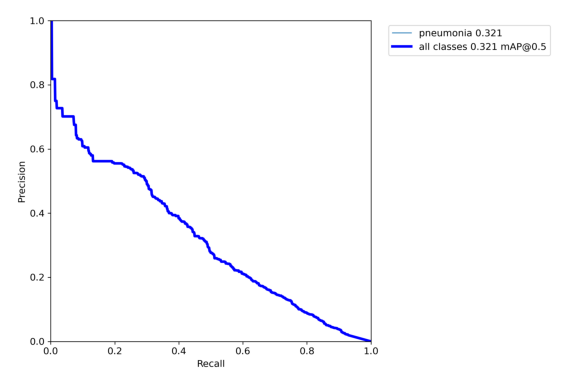

In [48]:
print ('The PR curve')
plt.figure(figsize=(10,10)) 
pr_curve_img=cv2.cvtColor(cv2.imread(PERFORMANCE_FILE_LOC+"/PR_curve.png"), cv2.COLOR_BGR2RGB)
plt.imshow(pr_curve_img);
plt.axis('off');

The Confusion matrix


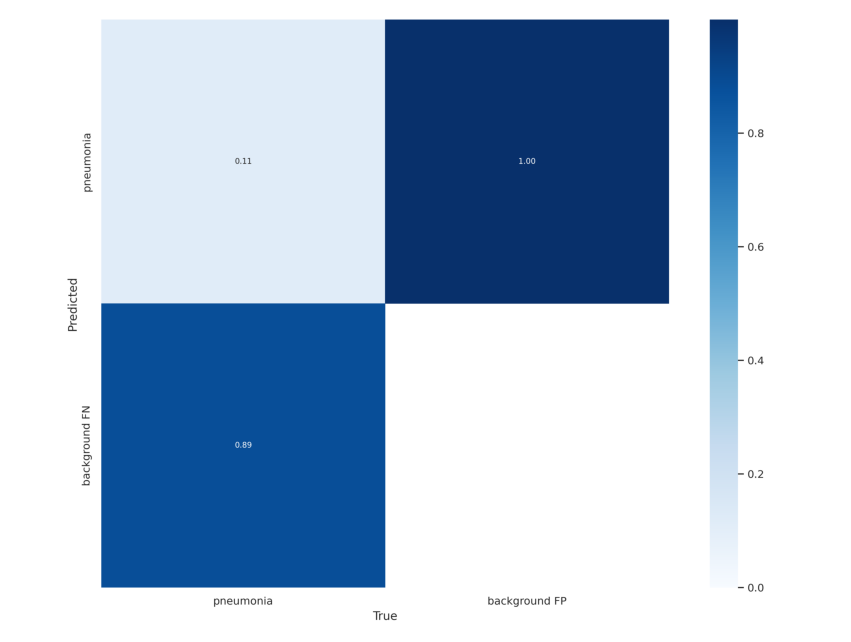

In [50]:
print ('The Confusion matrix')
plt.figure(figsize=(15,15)) 
pr_curve_img=cv2.cvtColor(cv2.imread(PERFORMANCE_FILE_LOC+"/confusion_matrix.png"), cv2.COLOR_BGR2RGB)
plt.imshow(pr_curve_img);
plt.axis('off');

Training details


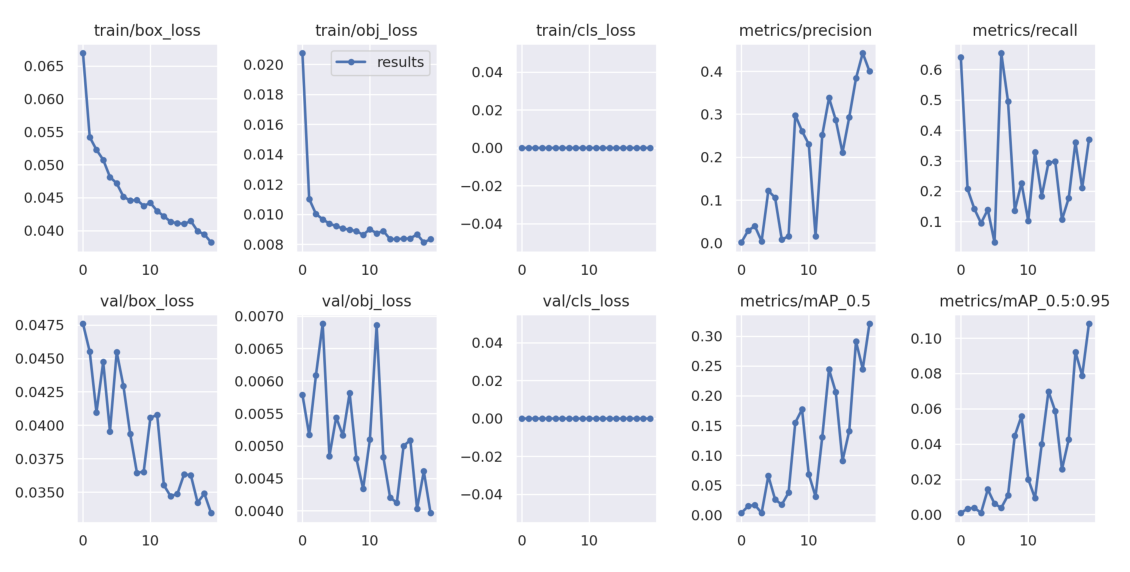

In [51]:
print ('Training details')
plt.figure(figsize=(20,20)) 
pr_curve_img=cv2.cvtColor(cv2.imread(PERFORMANCE_FILE_LOC+"/results.png"), cv2.COLOR_BGR2RGB)
plt.imshow(pr_curve_img);
plt.axis('off');

In [ ]:
# python train.py --weights path/to/best.pt  # start from pretrained model
#torch.save(model.state_dict(), path)
#yolo.save_weights()

In [57]:
TEST_PATH="/content/drive/My Drive/JPG_test"

In [63]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 1024 --conf 0.5 --source /content/drive/My Drive/JPG_test/

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--data DATA] [--imgsz IMGSZ [IMGSZ ...]]
                 [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-conf] [--save-crop] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
detect.py: error: unrecognized arguments: Drive/JPG_test/


In [ ]:
%cd ../
os.makedirs('pn_data/images/test', exist_ok=True)

In [ ]:
os.makedirs('pn_data/images/test', exist_ok=True)
## Copy files from sources to train
JPG_TEST = PATH+"JPG_test/"
## copy  train set
print ("Copying train")
length = len(os.listdir(JPG_TEST))
for j in range(length):
  for i in len(os.listdir(JPG_TEST)):
      src =(JPG_TEST+i)
      dst =("/content/pn_data/images/test/"+i)
      copyfile(src, dst)

In [ ]:
%cd yolov5

In [64]:
!python detect.py --img {IMG_SIZE} \
                  --weights /content/yolov5/runs/train/exp/weights/best.pt \
                  --conf 0.5 \
                  --source /content/drive/My Drive/JPG_test/ \

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--data DATA] [--imgsz IMGSZ [IMGSZ ...]]
                 [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-conf] [--save-crop] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
detect.py: error: unrecognized arguments: Drive/JPG_test/


In [ ]:
location='/content/yolov5/runs/detect/exp/'
results=[]
for files in os.listdir(location):
  if files.endswith(.txt):
      results.append(files)
print (len(results), " images found")

In [ ]:
print (results)

### Checking the output images


In [ ]:
display_images(results, location=location, num_samples=5, resize=FIG_SIZE )

In [ ]:
display_images(results, location=location, num_samples=5, resize=FIG_SIZE )